In [1]:
# =========================
# 0) path
# =========================
ROOT       = r"D:\bishe\data_nor_14_w3_64"       
PATH_JSON  = r"D:\bishe\avian\bird_eccv.json"    
PATH_PRIOR = r"D:\bishe\avian\pose_bone_prior.pth"  
SAVE_DIR   = r"D:\bishe\re_out"                  

import torch
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
LR         = 1e-3
EPOCHS     = 100          
VAL_SPLIT  = 0.1
SEED       = 42
PATIENCE   = 5            
IMPROVE_EPS= 1e-6         

In [2]:
# 1) import
# =========================
import os, json, gc, math, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms
from tqdm import tqdm

os.makedirs(SAVE_DIR, exist_ok=True)
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# =========================
# 2) def
# =========================
def rot6d_to_rotmat(x: torch.Tensor) -> torch.Tensor:
    """
    x: [B, 25*6]  ->  R: [B, 25, 3, 3]
    """
    B = x.shape[0]
    x = x.view(B, -1, 6)
    a1 = x[..., :3]
    a2 = x[..., 3:6]
    b1 = F.normalize(a1, dim=-1)
    b2 = F.normalize(a2 - (b1 * (a2 * b1).sum(dim=-1, keepdim=True)), dim=-1)
    b3 = torch.cross(b1, b2, dim=-1)
    return torch.stack([b1, b2, b3], dim=-2)


In [3]:
# 3) LBS & Bird model
# =========================
class LBS:
    def __init__(self, J, parents, weights):
        self.n_joints = J.shape[1]
        self.h_joints = F.pad(J.unsqueeze(-1), [0,0,0,1], value=0)
        self.kin_tree = torch.cat([J[:,[0], :], J[:, 1:] - J[:, parents[1:]]], dim=1).unsqueeze(-1)
        self.parents = parents
        self.weights = weights[None].float()

    def __call__(self, V, pose, bone, scale, to_rotmats=False):
        B = V.shape[0]; device = V.device
        V = F.pad(V.unsqueeze(-1), [0,0,0,1], value=1)  # [B,V,4,1]
        kin_tree = (scale * self.kin_tree) * bone[:, :, None, None]

        T = torch.zeros([B, self.n_joints, 4, 4], device=device, dtype=V.dtype)
        T[:, :, -1, -1] = 1
        T[:, :, :3, :]  = torch.cat([pose, kin_tree], dim=-1)

        T_rel = [T[:, 0]]
        for i in range(1, self.n_joints):
            T_rel.append(T_rel[self.parents[i]] @ T[:, i])
        T_rel = torch.stack(T_rel, dim=1)
        T_rel[:, :, :, [-1]] -= T_rel.clone() @ (self.h_joints * scale)

        T_ = self.weights @ T_rel.view(B, self.n_joints, -1)
        T_ = T_.view(B, -1, 4, 4)
        V = T_ @ V
        return V[:, :, :3, 0]  # [B,V,3]

class BirdModel:
    def __init__(self, json_path, prior_path=None, device="cpu"):
        self.device = device
        with open(json_path, "r") as f:
            dd = json.load(f)
        self.parents  = torch.tensor(dd["kintree_table"][0], device=device, dtype=torch.long)
        self.weights  = torch.tensor(dd["weights"], device=device).float()
        self.vert2kpt = torch.tensor(dd["vert2kpt"], device=device).float()  # [12, V]
        self.J = torch.tensor(dd["J"], device=device).unsqueeze(0).float()   # [1,J,3]
        self.V = torch.tensor(dd["V"], device=device).unsqueeze(0).float()   # [1,V,3]
        self.LBS = LBS(self.J, self.parents, self.weights)
        self.n_joints = self.J.shape[1]

        self.b_mean = None
        if prior_path and os.path.isfile(prior_path):
            prior = torch.load(prior_path, map_location=device)
            if "b_m" in prior:
                self.b_mean = prior["b_m"].to(device).float()

    def __call__(self, global_R, body_R, bone_length, scale=1.0):
        dtype = torch.float32
        global_R   = global_R.to(dtype)
        body_R     = body_R.to(dtype)
        bone_length= bone_length.to(dtype)

        B = global_R.shape[0]
        V = (self.V * scale).repeat([B,1,1]).to(dtype)

        bone = torch.cat([torch.ones([B,1], device=self.device, dtype=dtype), bone_length], dim=1)
        pose = torch.cat([global_R, body_R], dim=1)  # [B,25,3,3]

        verts = self.LBS(V, pose, bone, scale, to_rotmats=False)  # [B,V,3] float32
        kpts3d = torch.einsum("kv, bvd -> bkd", self.vert2kpt.to(dtype), verts)  # [B,12,3]
        return {"vertices": verts, "keypoints": kpts3d}


# Model define

In [ ]:
# 4) regressor（PoseNet + ShapeNet）
# =========================
class PoseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(36,512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(512,512), nn.BatchNorm1d(512), nn.ReLU())
        self.final  = nn.Linear(512, 25*6 + 3)
    def forward(self, x):
        return self.final(self.layer2(self.layer1(x)))

class ShapeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 8, 5, 2, 2), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(nn.Conv2d(8, 8, 3, 1, 1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(nn.Conv2d(8,16, 3, 1, 1), nn.BatchNorm2d(16),nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer4 = nn.Sequential(nn.Conv2d(16,32,3, 1, 1), nn.BatchNorm2d(32),nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer5 = nn.Sequential(nn.Conv2d(32,64,3, 1, 1), nn.BatchNorm2d(64),nn.ReLU(), nn.MaxPool2d(2,2))
        self.gap    = nn.AdaptiveAvgPool2d(1)
        self.fc     = nn.Linear(64, 24)
    def forward(self, x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        x = self.gap(x).flatten(1)   # [B,64]
        return self.fc(x)

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.pose_head  = PoseNet()
        self.shape_head = ShapeNet()
    def forward(self, k36, mask):
        pt   = self.pose_head(k36)    # [B,25*6+3]
        bone = self.shape_head(mask)  # [B,24]
        return pt, bone
    def postprocess(self, pt, bone):
        rot6d = pt[:, :-3]
        tran  = pt[:, -3:]
        R = rot6d_to_rotmat(rot6d)    # [B,25,3,3]
        return R, tran, bone

In [5]:
# 5) dataset（14→12  + mask）

AVIAN14_TO_MODEL12 = [0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 6]

class AvianDataset(Dataset):
    def __init__(self, root, to_mask_size=64):
        self.root = root
        self.ids  = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))])
        self.tfm_mask = transforms.Compose([
            transforms.Resize((to_mask_size, to_mask_size)),
            transforms.ToTensor(),   # -> [1,H,W],
        ])
    def __len__(self): return len(self.ids)
    def __getitem__(self, idx):
        sid = self.ids[idx]
        dd  = os.path.join(self.root, sid)

        k = np.load(os.path.join(dd, "keypoints14_norm.npy")).astype(np.float32)   # [14,2] or [14,3]
        kxy = k[:, :2]                                           # only (x,y) in [0,1]
        k36 = np.zeros(36, dtype=np.float32); k36[:28] = kxy.reshape(-1)  # 28 flatten + 8 个 0

        k12 = kxy[AVIAN14_TO_MODEL12]  # [12,2]

        m = Image.open(os.path.join(dd, "mask.png")).convert("L")
        m = self.tfm_mask(m)           # [1,H,W]

        item = {
            "id":   sid,
            "k36":  torch.from_numpy(k36),      # [36]
            "k12":  torch.from_numpy(k12),      # [12,2]
            "mask": m                           # [1,H,W]
        }
        return item

In [6]:
def project_points_lstsq_fp32(k3d, k2d):
    B, N, _ = k3d.shape
    ones = torch.ones(B, N, 1, device=k3d.device, dtype=k3d.dtype)
    A = torch.cat([k3d, ones], dim=-1)     # [B,12,4]

    A32 = A.float(); U32 = k2d.float()
    outs = []
    for b in range(B):
        sol = torch.linalg.lstsq(A32[b], U32[b]).solution  # [4,2]
        outs.append(A32[b] @ sol)                          # [12,2]
    return torch.stack(outs, 0)

def reproj_loss(U_pred, U_gt):
    return F.smooth_l1_loss(U_pred, U_gt, reduction="mean")

def bone_reg_loss(bone, bird: BirdModel, w=0.1):
    if bird.b_mean is None:
        return w * (bone**2).mean()
    return w * F.mse_loss(bone, bird.b_mean.expand_as(bone))

In [7]:
# 7) train/val
# =========================
full_ds = AvianDataset(ROOT, to_mask_size=64)
N = len(full_ds)
idx = np.arange(N); rng = np.random.RandomState(SEED); rng.shuffle(idx)
n_val = max(1, int(N * VAL_SPLIT))
val_idx = idx[:n_val]; train_idx = idx[n_val:]

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)

print(f"Train: {len(train_ds)}  Val: {len(val_ds)}  Total: {N}")


Train: 10610  Val: 1178  Total: 11788


In [8]:
# 8) net
# =========================
reg  = Regressor().to(DEVICE)
bird = BirdModel(PATH_JSON, prior_path=PATH_PRIOR, device=DEVICE)
opt  = torch.optim.Adam(reg.parameters(), lr=LR)

use_amp = (DEVICE == "cuda")
autocast = torch.amp.autocast
scaler   = torch.amp.GradScaler("cuda") if use_amp else None

# =========================
# 9) forward
# =========================
def forward_batch(batch):
    k36 = batch["k36"].to(DEVICE).float()     # [B,36]
    msk = batch["mask"].to(DEVICE).float()    # [B,1,H,W]
    k12 = batch["k12"].to(DEVICE).float()     # [B,12,2]

    with autocast("cuda", enabled=use_amp):
        pt, bone = reg(k36, msk)              # pt:[B,25*6+3], bone:[B,24]
        R, tran, bone = reg.postprocess(pt, bone)  # R:[B,25,3,3]

    R32    = R.float()
    bone32 = bone.float()
    out    = bird(R32[:, :1], R32[:, 1:], bone32, scale=1.0)
    k3d    = out["keypoints"]                # [B,12,3]

    U_pred = project_points_lstsq_fp32(k3d, k12)  # [B,12,2]
    loss_re = reproj_loss(U_pred, k12)
    loss_b  = bone_reg_loss(bone32, bird, w=0.1)
    loss    = loss_re + loss_b
    return loss, loss_re, loss_b


# Train

In [9]:
# 10) train
# =========================
hist = {"train_reproj":[], "train_bone":[], "train_total":[],
        "val_reproj":[],   "val_bone":[],   "val_total":[]}

best_val = math.inf
epochs_no_improve = 0
best_epoch = 0

best_path  = os.path.join(SAVE_DIR, "regressor_best.pth")
last_path  = os.path.join(SAVE_DIR, "regressor_last.pth")
final_path = os.path.join(SAVE_DIR, "regressor_final.pth")

for epoch in range(1, EPOCHS+1):
    # ----- Train -----
    reg.train()
    tr_re = tr_b = tr_tot = 0.0
    pbar = tqdm(train_dl, desc=f"Epoch {epoch:02d} [Train]", leave=False)
    for batch in pbar:
        opt.zero_grad(set_to_none=True)
        loss, loss_re, loss_b = forward_batch(batch)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            opt.step()

        tr_re  += float(loss_re.detach())
        tr_b   += float(loss_b.detach())
        tr_tot += float(loss.detach())
        pbar.set_postfix(reproj=f"{tr_re/(pbar.n+1):.4f}",
                         bone=f"{tr_b/(pbar.n+1):.4f}",
                         total=f"{tr_tot/(pbar.n+1):.4f}")

    n_tr = len(train_dl)
    tr_re_avg, tr_b_avg, tr_tot_avg = tr_re/n_tr, tr_b/n_tr, tr_tot/n_tr

    # ----- Val -----
    reg.eval()
    va_re = va_b = va_tot = 0.0
    with torch.no_grad():
        pbarv = tqdm(val_dl, desc=f"Epoch {epoch:02d} [Val]", leave=False)
        for batch in pbarv:
            loss, loss_re, loss_b = forward_batch(batch)
            va_re  += float(loss_re)
            va_b   += float(loss_b)
            va_tot += float(loss)
            pbarv.set_postfix(reproj=f"{va_re/(pbarv.n+1):.4f}",
                              bone=f"{va_b/(pbarv.n+1):.4f}",
                              total=f"{va_tot/(pbarv.n+1):.4f}")

    n_va = max(1, len(val_dl))
    va_re_avg, va_b_avg, va_tot_avg = va_re/n_va, va_b/n_va, va_tot/n_va

    # —— save —— #
    torch.save({
        "epoch": epoch,
        "model_state_dict": reg.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
    }, last_path)

    # —— print —— #
    hist["train_reproj"].append(tr_re_avg);  hist["train_bone"].append(tr_b_avg);  hist["train_total"].append(tr_tot_avg)
    hist["val_reproj"].append(va_re_avg);    hist["val_bone"].append(va_b_avg);    hist["val_total"].append(va_tot_avg)
    print(f"[Epoch {epoch:02d}] "
          f"Train  reproj={tr_re_avg:.4f}  bone={tr_b_avg:.4f}  total={tr_tot_avg:.4f} | "
          f"Val  reproj={va_re_avg:.4f}  bone={va_b_avg:.4f}  total={va_tot_avg:.4f}")

    # —— best early stop —— #
    if va_tot_avg < best_val - IMPROVE_EPS:
        best_val = va_tot_avg
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": reg.state_dict(),
            "optimizer_state_dict": opt.state_dict(),
            "best_val": best_val
        }, best_path)
        print(f"  ↳ ✅ upload new：{best_path} (epoch={epoch}, val_total={best_val:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement on validation set（{epochs_no_improve}/{PATIENCE}）")
        if epochs_no_improve >= PATIENCE:
            print(f"🛑 early stop：continue {PATIENCE}  epoch No improvement on validation set。best epoch = {best_epoch}，val_total = {best_val:.4f}")
            break

    gc.collect()
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

# —— save final —— #
torch.save({"model_state_dict": reg.state_dict(), "hist": hist}, final_path)
print(f"✅ finish。best：\n  best  → {best_path}\n  last  → {last_path}\n  final → {final_path}")

[Epoch 01] Train  reproj=0.0152  bone=0.0018  total=0.0170 | Val  reproj=0.0086  bone=0.0002  total=0.0088
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=1, val_total=0.0088)


[Epoch 02] Train  reproj=0.0084  bone=0.0004  total=0.0088 | Val  reproj=0.0078  bone=0.0003  total=0.0081
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=2, val_total=0.0081)


[Epoch 03] Train  reproj=0.0067  bone=0.0003  total=0.0071 | Val  reproj=0.0061  bone=0.0002  total=0.0063
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=3, val_total=0.0063)


[Epoch 04] Train  reproj=0.0063  bone=0.0003  total=0.0065 | Val  reproj=0.0052  bone=0.0002  total=0.0054
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=4, val_total=0.0054)


[Epoch 05] Train  reproj=0.0057  bone=0.0003  total=0.0059 | Val  reproj=0.0044  bone=0.0001  total=0.0045
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=5, val_total=0.0045)


[Epoch 06] Train  reproj=0.0054  bone=0.0002  total=0.0056 | Val  reproj=0.0051  bone=0.0001  total=0.0052
  ↳ 验证集无提升（1/5）


[Epoch 07] Train  reproj=0.0048  bone=0.0002  total=0.0050 | Val  reproj=0.0051  bone=0.0002  total=0.0053
  ↳ 验证集无提升（2/5）


[Epoch 08] Train  reproj=0.0043  bone=0.0002  total=0.0045 | Val  reproj=0.0042  bone=0.0001  total=0.0043
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=8, val_total=0.0043)


[Epoch 09] Train  reproj=0.0040  bone=0.0001  total=0.0041 | Val  reproj=0.0058  bone=0.0009  total=0.0067
  ↳ 验证集无提升（1/5）


[Epoch 10] Train  reproj=0.0041  bone=0.0002  total=0.0043 | Val  reproj=0.0042  bone=0.0003  total=0.0045
  ↳ 验证集无提升（2/5）


[Epoch 11] Train  reproj=0.0041  bone=0.0001  total=0.0042 | Val  reproj=0.0038  bone=0.0000  total=0.0039
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=11, val_total=0.0039)


[Epoch 12] Train  reproj=0.0041  bone=0.0001  total=0.0042 | Val  reproj=0.0036  bone=0.0001  total=0.0037
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=12, val_total=0.0037)


[Epoch 13] Train  reproj=0.0038  bone=0.0001  total=0.0039 | Val  reproj=0.0046  bone=0.0003  total=0.0049
  ↳ 验证集无提升（1/5）


[Epoch 14] Train  reproj=0.0034  bone=0.0001  total=0.0035 | Val  reproj=0.0036  bone=0.0003  total=0.0039
  ↳ 验证集无提升（2/5）


[Epoch 15] Train  reproj=0.0032  bone=0.0001  total=0.0033 | Val  reproj=0.0038  bone=0.0001  total=0.0039
  ↳ 验证集无提升（3/5）


[Epoch 16] Train  reproj=0.0032  bone=0.0001  total=0.0033 | Val  reproj=0.0034  bone=0.0001  total=0.0035
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=16, val_total=0.0035)


[Epoch 17] Train  reproj=0.0033  bone=0.0001  total=0.0034 | Val  reproj=0.0030  bone=0.0001  total=0.0032
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=17, val_total=0.0032)


[Epoch 18] Train  reproj=0.0029  bone=0.0001  total=0.0030 | Val  reproj=0.0025  bone=0.0001  total=0.0026
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=18, val_total=0.0026)


[Epoch 19] Train  reproj=0.0029  bone=0.0001  total=0.0029 | Val  reproj=0.0026  bone=0.0000  total=0.0026
  ↳ 验证集无提升（1/5）


[Epoch 20] Train  reproj=0.0028  bone=0.0001  total=0.0029 | Val  reproj=0.0032  bone=0.0001  total=0.0033
  ↳ 验证集无提升（2/5）


[Epoch 21] Train  reproj=0.0028  bone=0.0001  total=0.0029 | Val  reproj=0.0024  bone=0.0001  total=0.0024
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=21, val_total=0.0024)


[Epoch 22] Train  reproj=0.0028  bone=0.0001  total=0.0029 | Val  reproj=0.0023  bone=0.0000  total=0.0024
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=22, val_total=0.0024)


[Epoch 23] Train  reproj=0.0026  bone=0.0001  total=0.0027 | Val  reproj=0.0025  bone=0.0001  total=0.0026
  ↳ 验证集无提升（1/5）


[Epoch 24] Train  reproj=0.0026  bone=0.0001  total=0.0026 | Val  reproj=0.0024  bone=0.0001  total=0.0025
  ↳ 验证集无提升（2/5）


[Epoch 25] Train  reproj=0.0025  bone=0.0001  total=0.0025 | Val  reproj=0.0022  bone=0.0000  total=0.0023
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=25, val_total=0.0023)


[Epoch 26] Train  reproj=0.0023  bone=0.0000  total=0.0023 | Val  reproj=0.0026  bone=0.0000  total=0.0027
  ↳ 验证集无提升（1/5）


[Epoch 27] Train  reproj=0.0023  bone=0.0001  total=0.0023 | Val  reproj=0.0025  bone=0.0000  total=0.0025
  ↳ 验证集无提升（2/5）


[Epoch 28] Train  reproj=0.0023  bone=0.0001  total=0.0023 | Val  reproj=0.0022  bone=0.0000  total=0.0022
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=28, val_total=0.0022)


[Epoch 29] Train  reproj=0.0024  bone=0.0001  total=0.0025 | Val  reproj=0.0024  bone=0.0000  total=0.0024
  ↳ 验证集无提升（1/5）


[Epoch 30] Train  reproj=0.0023  bone=0.0001  total=0.0023 | Val  reproj=0.0021  bone=0.0000  total=0.0021
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=30, val_total=0.0021)


[Epoch 31] Train  reproj=0.0023  bone=0.0001  total=0.0023 | Val  reproj=0.0021  bone=0.0001  total=0.0021
  ↳ 验证集无提升（1/5）


[Epoch 32] Train  reproj=0.0023  bone=0.0000  total=0.0023 | Val  reproj=0.0021  bone=0.0001  total=0.0021
  ↳ 验证集无提升（2/5）


[Epoch 33] Train  reproj=0.0022  bone=0.0000  total=0.0022 | Val  reproj=0.0020  bone=0.0000  total=0.0021
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=33, val_total=0.0021)


[Epoch 34] Train  reproj=0.0021  bone=0.0000  total=0.0021 | Val  reproj=0.0021  bone=0.0000  total=0.0021
  ↳ 验证集无提升（1/5）


[Epoch 35] Train  reproj=0.0021  bone=0.0001  total=0.0021 | Val  reproj=0.0028  bone=0.0001  total=0.0028
  ↳ 验证集无提升（2/5）


[Epoch 36] Train  reproj=0.0021  bone=0.0000  total=0.0022 | Val  reproj=0.0020  bone=0.0001  total=0.0021
  ↳ 验证集无提升（3/5）


[Epoch 37] Train  reproj=0.0020  bone=0.0000  total=0.0020 | Val  reproj=0.0018  bone=0.0000  total=0.0018
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=37, val_total=0.0018)


[Epoch 38] Train  reproj=0.0020  bone=0.0000  total=0.0020 | Val  reproj=0.0024  bone=0.0000  total=0.0024
  ↳ 验证集无提升（1/5）


[Epoch 39] Train  reproj=0.0020  bone=0.0000  total=0.0020 | Val  reproj=0.0018  bone=0.0000  total=0.0019
  ↳ 验证集无提升（2/5）


[Epoch 40] Train  reproj=0.0020  bone=0.0000  total=0.0020 | Val  reproj=0.0019  bone=0.0001  total=0.0020
  ↳ 验证集无提升（3/5）


[Epoch 41] Train  reproj=0.0019  bone=0.0000  total=0.0020 | Val  reproj=0.0020  bone=0.0000  total=0.0020
  ↳ 验证集无提升（4/5）


[Epoch 42] Train  reproj=0.0019  bone=0.0000  total=0.0019 | Val  reproj=0.0018  bone=0.0000  total=0.0018
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=42, val_total=0.0018)


[Epoch 43] Train  reproj=0.0019  bone=0.0000  total=0.0019 | Val  reproj=0.0021  bone=0.0001  total=0.0022
  ↳ 验证集无提升（1/5）


[Epoch 44] Train  reproj=0.0018  bone=0.0000  total=0.0018 | Val  reproj=0.0018  bone=0.0000  total=0.0019
  ↳ 验证集无提升（2/5）


[Epoch 45] Train  reproj=0.0018  bone=0.0000  total=0.0019 | Val  reproj=0.0019  bone=0.0001  total=0.0019
  ↳ 验证集无提升（3/5）


[Epoch 46] Train  reproj=0.0018  bone=0.0000  total=0.0019 | Val  reproj=0.0018  bone=0.0000  total=0.0019
  ↳ 验证集无提升（4/5）


[Epoch 47] Train  reproj=0.0017  bone=0.0000  total=0.0018 | Val  reproj=0.0017  bone=0.0000  total=0.0018
  ↳ ✅ 最优模型更新：D:\bishe\re_out\regressor_best.pth (epoch=47, val_total=0.0018)


[Epoch 48] Train  reproj=0.0018  bone=0.0000  total=0.0019 | Val  reproj=0.0019  bone=0.0000  total=0.0020
  ↳ 验证集无提升（1/5）


[Epoch 49] Train  reproj=0.0019  bone=0.0000  total=0.0019 | Val  reproj=0.0020  bone=0.0000  total=0.0020
  ↳ 验证集无提升（2/5）


[Epoch 50] Train  reproj=0.0018  bone=0.0000  total=0.0019 | Val  reproj=0.0024  bone=0.0001  total=0.0025
  ↳ 验证集无提升（3/5）


[Epoch 51] Train  reproj=0.0017  bone=0.0000  total=0.0018 | Val  reproj=0.0019  bone=0.0000  total=0.0019
  ↳ 验证集无提升（4/5）


[Epoch 52] Train  reproj=0.0017  bone=0.0000  total=0.0017 | Val  reproj=0.0023  bone=0.0001  total=0.0023
  ↳ 验证集无提升（5/5）
🛑 早停触发：连续 5 个 epoch 验证集无提升。最佳 epoch = 47，val_total = 0.0018
✅ 结束。已保存：
  best  → D:\bishe\re_out\regressor_best.pth
  last  → D:\bishe\re_out\regressor_last.pth
  final → D:\bishe\re_out\regressor_final.pth


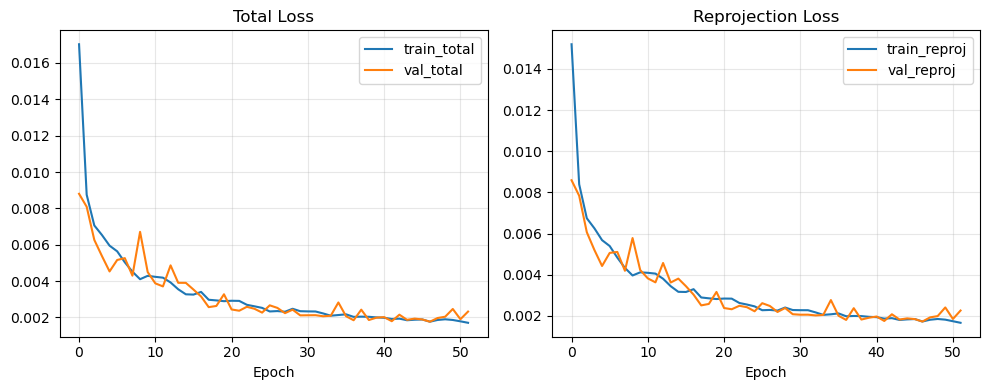

📈 曲线图已保存到： D:\bishe\re_out\loss_curves.png


In [10]:
# =========================
# 11) loss save
# =========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist["train_total"], label="train_total")
plt.plot(hist["val_total"],   label="val_total")
plt.title("Total Loss"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(hist["train_reproj"], label="train_reproj")
plt.plot(hist["val_reproj"],   label="val_reproj")
plt.title("Reprojection Loss"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
curve_path = os.path.join(SAVE_DIR, "loss_curves.png")
plt.savefig(curve_path, dpi=150)
plt.show()
print("📈 curve save：", curve_path)

# visualization

load_state_dict missing: []
load_state_dict unexpected: []


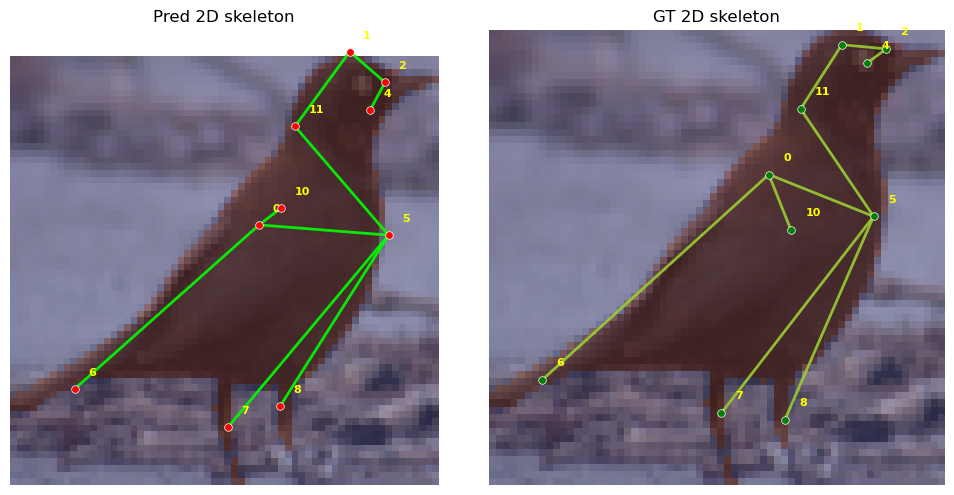

In [1]:
# =========================
# 0) change path
# =========================
ROOT       = r"D:\bishe\data_nor_14_w3_64"               
SID        = "000570"                                   
PATH_JSON  = r"D:\bishe\avian\bird_eccv.json"           
PATH_PRIOR = r"D:\bishe\avian\pose_bone_prior.pth"       
CKPT_PATH  = r"D:\bishe\re_out\regressor_best.pth"       

import os, json, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# 1) tools
# =========================
def rot6d_to_rotmat(x: torch.Tensor) -> torch.Tensor:
    B = x.shape[0]
    x = x.view(B, -1, 6)
    a1 = x[..., :3]
    a2 = x[..., 3:6]
    b1 = F.normalize(a1, dim=-1)
    b2 = F.normalize(a2 - (b1 * (a2*b1).sum(dim=-1, keepdim=True)), dim=-1)
    b3 = torch.cross(b1, b2, dim=-1)
    return torch.stack([b1, b2, b3], dim=-2)

class LBS:
    def __init__(self, J, parents, weights):
        self.n_joints = J.shape[1]
        self.h_joints = F.pad(J.unsqueeze(-1), [0,0,0,1], value=0)
        self.kin_tree = torch.cat([J[:,[0], :], J[:, 1:]-J[:, parents[1:]]], dim=1).unsqueeze(-1)
        self.parents = parents
        self.weights = weights[None].float()
    def __call__(self, V, pose, bone, scale, to_rotmats=False):
        B = V.shape[0]; device = V.device
        V = F.pad(V.unsqueeze(-1), [0,0,0,1], value=1)                 # [B,V,4,1]
        kin_tree = (scale*self.kin_tree) * bone[:, :, None, None]      # [B,J,3,1]
        T = torch.zeros([B, self.n_joints, 4, 4], device=device, dtype=V.dtype)
        T[:, :, -1, -1] = 1
        T[:, :, :3, :]  = torch.cat([pose, kin_tree], dim=-1)
        T_rel = [T[:, 0]]
        for i in range(1, self.n_joints):
            T_rel.append(T_rel[self.parents[i]] @ T[:, i])
        T_rel = torch.stack(T_rel, dim=1)
        T_rel[:,:,:,[-1]] -= T_rel.clone() @ (self.h_joints*scale)
        T_ = self.weights @ T_rel.view(B, self.n_joints, -1)
        T_ = T_.view(B, -1, 4, 4)
        V = T_ @ V
        return V[:, :, :3, 0]  # [B,V,3]

class BirdModel:
    def __init__(self, json_path, prior_path=None, device="cpu"):
        self.device = device
        with open(json_path, "r") as f:
            dd = json.load(f)
        self.parents  = torch.tensor(dd["kintree_table"][0], device=device, dtype=torch.long)
        self.weights  = torch.tensor(dd["weights"], device=device).float()
        self.vert2kpt = torch.tensor(dd["vert2kpt"], device=device).float()  # [12,V]
        self.J = torch.tensor(dd["J"], device=device).unsqueeze(0).float()
        self.V = torch.tensor(dd["V"], device=device).unsqueeze(0).float()
        self.LBS = LBS(self.J, self.parents, self.weights)
        self.n_joints = self.J.shape[1]
        self.b_mean = None
        if prior_path and os.path.isfile(prior_path):
            prior = torch.load(prior_path, map_location=device)
            if "b_m" in prior: self.b_mean = prior["b_m"].to(device).float()
    def __call__(self, global_R, body_R, bone, scale=1.0):
        B = global_R.shape[0]; dtype = torch.float32
        V = (self.V * scale).repeat([B,1,1]).to(dtype)
        pose = torch.cat([global_R.to(dtype), body_R.to(dtype)], dim=1)
        bone = torch.cat([torch.ones([B,1], device=self.device, dtype=dtype), bone.to(dtype)], dim=1)
        verts = self.LBS(V, pose, bone, scale, to_rotmats=False)
        k3d   = torch.einsum("kv,bvd->bkd", self.vert2kpt.to(dtype), verts)  # [B,12,3]
        return {"vertices": verts, "keypoints": k3d}

# regesstor
class PoseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(36,512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(512,512), nn.BatchNorm1d(512), nn.ReLU())
        self.final  = nn.Linear(512, 25*6 + 3)
    def forward(self, x):
        x = self.layer1(x); x = self.layer2(x); return self.final(x)

class ShapeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 8, 5, 2, 2), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(nn.Conv2d(8, 8, 3, 1, 1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(nn.Conv2d(8,16, 3, 1, 1), nn.BatchNorm2d(16),nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer4 = nn.Sequential(nn.Conv2d(16,32,3, 1, 1), nn.BatchNorm2d(32),nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer5 = nn.Sequential(nn.Conv2d(32,64,3, 1, 1), nn.BatchNorm2d(64),nn.ReLU(), nn.MaxPool2d(2,2))
        self.gap    = nn.AdaptiveAvgPool2d(1)
        self.fc     = nn.Linear(64, 24)
    def forward(self, x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        return self.fc(self.gap(x).flatten(1))

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.pose_head  = PoseNet()
        self.shape_head = ShapeNet()
    def forward(self, k36, mask):
        return self.pose_head(k36), self.shape_head(mask)
    def postprocess(self, pt, bone):
        R = rot6d_to_rotmat(pt[:, :-3]); t = pt[:, -3:]
        return R, t, bone

def load_regressor_compat(reg, ckpt_path, device):
    if not os.path.isfile(ckpt_path):
        print("⚠️ pass：", ckpt_path)
        return reg
    ckpt = torch.load(ckpt_path, map_location=device)
    sd = ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt
    from collections import OrderedDict
    new_sd = OrderedDict()
    for k,v in sd.items():
        nk = k
        new_sd[nk] = v
    missing, unexpected = reg.load_state_dict(new_sd, strict=False)
    print("load_state_dict missing:", missing)
    print("load_state_dict unexpected:", unexpected)
    return reg

# =========================
# 2) data lode single
# =========================
AVIAN14_TO_MODEL12 = [0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 6]

ddir = os.path.join(ROOT, SID)
img  = Image.open(os.path.join(ddir, "image.png")).convert("RGB")
mask = Image.open(os.path.join(ddir, "mask.png")).convert("L")
k14  = np.load(os.path.join(ddir, "keypoints14_norm.npy")).astype(np.float32)  # [14,2]或[14,3]

# 12
k12 = k14[:, :2][AVIAN14_TO_MODEL12]            # [12,2] in [0,1]
k12_t = torch.from_numpy(k12).unsqueeze(0).to(DEVICE).float()

# get input
kxy = k14[:, :2]
k36 = np.zeros(36, np.float32); k36[:28] = kxy.reshape(-1)
k36_t = torch.from_numpy(k36).unsqueeze(0).to(DEVICE).float()

tfm = T.Compose([T.Resize((64,64)), T.ToTensor()])
m64_t = tfm(mask).unsqueeze(0).to(DEVICE).float()   # [1,1,64,64]

# =========================
# 3) Visibility/Validity processing
# =========================
if k14.shape[1] >= 3:
    vis14 = (k14[:,2] > 0.5)
    valid12 = vis14[AVIAN14_TO_MODEL12]
else:
    valid12 = ~((k12[:,0]==0) & (k12[:,1]==0))
valid12_t = torch.from_numpy(valid12.astype(np.bool_)).unsqueeze(0).to(DEVICE)  # [1,12]

# =========================
# 4) Forward reasoning
# =========================
reg  = Regressor().to(DEVICE).eval()
reg  = load_regressor_compat(reg, CKPT_PATH, DEVICE)
bird = BirdModel(PATH_JSON, PATH_PRIOR, device=DEVICE)

with torch.no_grad():
    pt, bone = reg(k36_t, m64_t)
    R, t, bone = reg.postprocess(pt, bone)
    out = bird(R[:, :1], R[:, 1:], bone, scale=1.0)
    k3d = out["keypoints"]        # [1,12,3]


# =========================
def project_points_lstsq_valid(k3d, k2d, valid=None):
    B, N, _ = k3d.shape
    out = torch.zeros_like(k2d)
    ones = torch.ones(B, N, 1, device=k3d.device, dtype=k3d.dtype)
    for b in range(B):
        m = torch.ones(N, dtype=torch.bool, device=k3d.device) if valid is None else valid[b].bool()
        if m.sum() >= 4:
            A = torch.cat([k3d[b, m], torch.ones(m.sum(),1, device=k3d.device, dtype=k3d.dtype)], dim=-1).float() # [M,4]
            U = k2d[b, m].float()                                                                                # [M,2]
            sol = torch.linalg.lstsq(A, U).solution                                                              # [4,2]
            Aall = torch.cat([k3d[b], ones[b]], dim=-1).float()                                                  # [12,4]
            out[b] = Aall @ sol                                                                                  # [12,2]
        else:
            out[b] = k2d[b]
    return out

U_pred = project_points_lstsq_valid(k3d, k12_t, valid12_t)  # [1,12,2]

# =========================
E12 = [
    (2,1),(1,11),(2,3),(2,4),  # 
    (11,5),(5,0),(0,6),        # 
    (0,9),(0,10),              
    (5,7),(5,8),               
]

def draw_skeleton(ax, pts_xy, valid_mask, edges, title=None, c_point='r', c_line='lime'):
    for i, j in edges:
        if valid_mask[i] and valid_mask[j]:
            ax.plot([pts_xy[i,0], pts_xy[j,0]],[pts_xy[i,1], pts_xy[j,1]], '-', lw=2, color=c_line, alpha=0.9)
    for idx, (x,y) in enumerate(pts_xy):
        if valid_mask[idx]:
            ax.scatter(x, y, s=30, c=c_point, edgecolors='white', linewidths=0.5, zorder=3)
            ax.text(x+2, y-2, str(idx), color='yellow', fontsize=8, weight='bold')
    if title: ax.set_title(title)
    ax.axis('off')


W, H = img.size
U_pred_np = U_pred[0].cpu().numpy().copy(); U_pred_np[:,0]*=W; U_pred_np[:,1]*=H
U_gt_np   = k12.copy();                   U_gt_np[:,0]*=W;    U_gt_np[:,1]*=H
valid_np  = valid12.astype(bool)

fig, ax = plt.subplots(1,2, figsize=(10,5))
# pre
ax[0].imshow(img); ax[0].imshow(mask.resize((W,H)), cmap='jet', alpha=0.25)
draw_skeleton(ax[0], U_pred_np, valid_np, E12, title="Pred 2D skeleton", c_point='r', c_line='lime')
# GT
ax[1].imshow(img); ax[1].imshow(mask.resize((W,H)), cmap='jet', alpha=0.25)
draw_skeleton(ax[1], U_gt_np,   valid_np, E12, title="GT 2D skeleton",   c_point='g', c_line='yellowgreen')
plt.tight_layout(); plt.show()


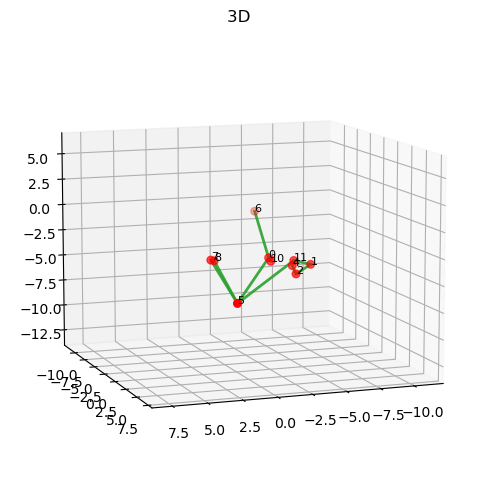

In [ ]:
# ========= 4) 3d visualization=========
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

def set_axes_equal(ax):
    x_limits = ax.get_xlim3d(); y_limits = ax.get_ylim3d(); z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0]); x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0]); y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0]); z_middle = np.mean(z_limits)
    plot_radius = 0.5*max([x_range, y_range, z_range])
    ax.set_xlim3d([x_middle-plot_radius, x_middle+plot_radius])
    ax.set_ylim3d([y_middle-plot_radius, y_middle+plot_radius])
    ax.set_zlim3d([z_middle-plot_radius, z_middle+plot_radius])


E12 = [
    (2,1),(1,11),(2,3),(2,4),  # 
    (11,5),(5,0),(0,6),        # 
    (0,9),(0,10),              # 
    (5,7),(5,8),               # 
]

# ---- 3D skeleton ----
P = k3d[0].detach().cpu().numpy()     # [12,3]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')


if 'valid_np' in globals(): valid3d = valid_np
else: valid3d = np.ones(len(P), dtype=bool)

for i, j in E12:
    if valid3d[i] and valid3d[j]:
        xs, ys, zs = P[[i,j],0], P[[i,j],1], P[[i,j],2]
        ax.plot(xs, ys, zs, lw=2, color='tab:green', alpha=0.9)

ax.scatter(P[valid3d,0], P[valid3d,1], P[valid3d,2], s=30, c='r')
for i,(x,y,z) in enumerate(P):
    if valid3d[i]:
        ax.text(x, y, z, str(i), color='k', fontsize=8)

ax.set_title("3D ")
ax.view_init(elev=10, azim=70); set_axes_equal(ax)
plt.show()

V = out["vertices"][0].detach().cpu().numpy()  # [V,3]
if hasattr(bird, "F"):
    F_tri = bird.F.cpu().numpy()
else:
    import json
    with open(PATH_JSON, "r") as f:
        F_tri = np.array(json.load(f)["F"], dtype=np.int32)  # [F,3]

mesh_tris = V[F_tri]  # [F,3,3]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
poly = Poly3DCollection(mesh_tris, alpha=0.7, facecolor=(0.6,0.6,0.8,0.8))
poly.set_edgecolor((0,0,0,0.05))
ax.add_collection3d(poly)

ax.scatter(P[valid3d,0], P[valid3d,1], P[valid3d,2], s=15, c='r', depthshade=True)
for i,(x,y,z) in enumerate(P):
    if valid3d[i]:
        ax.text(x, y, z, str(i), color='k', fontsize=8)

ax.set_title("mash + 3D ")
mins, maxs = V.min(axis=0), V.max(axis=0)
ax.set_xlim(mins[0], maxs[0]); ax.set_ylim(mins[1], maxs[1]); ax.set_zlim(mins[2], maxs[2])
ax.view_init(elev=10, azim=70); set_axes_equal(ax)
plt.show()
